# The Data on the Data Job Hunt
### Cleaning and NLP Analysis of Indeed Job Postings

The goal of this analysis is to first clean the data and then begin processing the data to be prepared for machine learning. The goal of the machine learning will be to classify jobs that don't explicitly state their title into one of three catagories: Data Analyist, Data Scientist, or Data Engineer. 

Along the way will will look at geographic hubs for these types of positions, both cities and states. Additionally we will look at the skills required by each position as well as if these skills are transferable between positions or unique.

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import pprint
%matplotlib inline

In [6]:
data=pd.read_csv("alldata.csv")

In [7]:
data.head()

,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


### Cleaning the Location

After a quick look, it appears that our first orders of cleaning are to standardize the location column to only contain the city and the state. This will allowed more targeting of geographic areas in our search, and allow us to split it later.


In [8]:
def loc_cleaner(string): #A function to remove zip codes from all locations.
    string=str(string)
    new=re.sub("\d{1,5}", "", string)
    return new

loc_cleaner("this is a test 12345")

'this is a test '

In [9]:
data['location']=data['location'].apply(loc_cleaner) 
data['location']=data['location'].str.rstrip()

In [10]:
data['location'].value_counts()

New York, NY                  848
Seattle, WA                   777
Cambridge, MA                 694
Boston, MA                    629
San Francisco, CA             564
Chicago, IL                   471
San Diego, CA                 412
Washington, DC                340
Mountain View, CA             277
Atlanta, GA                   269
Sunnyvale, CA                 256
Los Angeles, CA               254
Boulder, CO                   251
Austin, TX                    213
Redmond, WA                   158
South San Francisco, CA        73
Redwood City, CA               59
Oakland, CA                    34
San Mateo, CA                  30
Manhattan, NY                  30
San Francisco Bay Area, CA     26
Berkeley, CA                   19
Emeryville, CA                 19
Jersey City, NJ                17
San Carlos, CA                 16
Queens, NY                     15
Foster City, CA                14
Menlo Park, CA                 14
Brooklyn, NY                   14
Novato, CA    

Now that we have removed the zip codes from the locations, we turn to areas that have other geographic specifiers such as the San Fransisco area which contains modifiers such as "South", "Bay Area" and others. 

In [11]:
def San_Fran_mask(string):
    string=str(string)
    mask="San Francisco" in string
    return mask



In [12]:
San_Fran_bools=data['location'].apply(San_Fran_mask)
San_Fran=data[San_Fran_bools]
San_Fran['location'].value_counts()


San Francisco, CA             564
South San Francisco, CA        73
San Francisco Bay Area, CA     26
Name: location, dtype: int64

Now we see that the variations are limited to "San Francisco Bay Area" and "South San Francisco" so we will remove these to continue standardizing. 

In [13]:
def clean_san_fran(string):
    remove=["South ", ' Bay Area']
    string=str(string)
    for offender in remove:
        string=string.replace(offender, "")
    return string

data['location']=data['location'].apply(clean_san_fran)

In [14]:
data['location'].value_counts()

New York, NY         848
Seattle, WA          777
Cambridge, MA        694
San Francisco, CA    663
Boston, MA           629
Chicago, IL          471
San Diego, CA        412
Washington, DC       340
Mountain View, CA    277
Atlanta, GA          269
Sunnyvale, CA        256
Los Angeles, CA      254
Boulder, CO          251
Austin, TX           213
Redmond, WA          158
Redwood City, CA      59
Oakland, CA           34
San Mateo, CA         30
Manhattan, NY         30
Berkeley, CA          19
Emeryville, CA        19
Jersey City, NJ       17
San Carlos, CA        16
Queens, NY            15
Menlo Park, CA        14
Foster City, CA       14
Brooklyn, NY          14
Novato, CA            12
nan                   11
Hayward, CA           10
                    ... 
Cedar Park, TX         1
New Hyde Park, NY      1
Bedminster, NJ         1
Oakland, NJ            1
Kenilworth, NJ         1
Secaucus, NJ           1
Fairfield, NJ          1
Fremont, CA            1
Rutherford, NJ         1


In [15]:
data['city']=data['location'].str.split(",").str[0]
data['state']=data['location'].str.split(",").str[1].str.lstrip()
data.drop('location', axis=1, inplace=True)

In [16]:
data.head()

,position,company,description,reviews,city,state
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,Atlanta,GA
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,Atlanta,GA
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,Atlanta,GA
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,Atlanta,GA
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,Atlanta,GA


Text(0.5, 1.0, 'Frequency of Data Jobs by State')

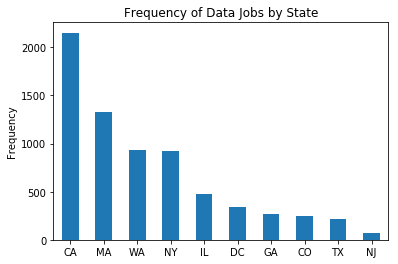

In [17]:
data['state'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel("Frequency")
plt.title("Frequency of Data Jobs by State")

We can see that California dominates Data Science positions which is something we expected. Interestingly, massachusetts beats out both Washington and New York for second place. Most surprising from this chart is that there are realatively few states in the mix. Given how often we hear about the prevalance of Data positions, more metro areas were expected. 

### Removing Rows and Columns That Aren't Helpful

The column reviews is roughly 20% null and cannot be used to help the prediction; it will be removed.

In [18]:
data['reviews'].isnull().sum()

1638

In [19]:
data=data.drop('reviews', axis=1)

In [20]:
data.columns

Index(['position', 'company', 'description', 'city', 'state'], dtype='object')

In [21]:
data.isnull().sum()

position       11
company        11
description    11
city            0
state          11
dtype: int64

There are eleven rows with null position, these cannot be used to predict the title, so they will be removed.

In [22]:
data.shape

(6964, 5)

In [23]:
data=data.dropna()
data.isnull().sum()

position       0
company        0
description    0
city           0
state          0
dtype: int64

Now that all the null values are removed, extraction can begin.

### Extracting Skill Data from Descriptions

We now want to prep the data for machine learning, this will involve two major steps, the first of which is to extract key points from the description column and translate them into meaningful skillsets. These skill sets can then be used to help determine what the position is, if it isn't stated in the job title. 

In [24]:
data['description']=data['description'].str.lower().replace("\n", " ")

In [25]:
punctuation=[',', '.', '(', ')', '""', '-', '*', '?', '!']
for thing in punctuation:
   data['description'] = data['description'].str.replace(thing, " ")

So far we have standardized capitalization to lowercase and removed punctuation marks. We will now look to extract key skills for each position.

In [42]:

#somewhat arbitrary skills that these jobs use.
hard_skills=['python',
             'hadoop',
             'sql',
             'pandas', 
             'machine learning',
             'statistics',
             ' r ',
             'visualization', 
             'pipelines', 
             'spark',
             'excel',
             'cleaning', 
             'matlab',
             'tableau',
             'database',
             'analysis',
             'nosql',
             'tensorflow',
             'scala',
             'ai',
             'unstructured',
             
             
            ]

#checks each string for key term and if it is present adds it to a list which is being check for duplicates
def skillz(string): 
    empty=[]
    string=str(string)
    for skill in hard_skills:
        if skill in string:
            empty.append(skill)
    empty=list(dict.fromkeys(empty))
    
    return empty

data['hard skills']=data['description'].apply(skillz)



In [43]:
data['hard skills'].head()

0                                    [excel, database]
1       [statistics, excel, database, analysis, scala]
2    [python, hadoop, sql, machine learning,  r , v...
3    [python, sql,  r , visualization, tableau, dat...
4               [machine learning, database, analysis]
Name: hard skills, dtype: object

We have now extracted hard skills from each listing giving us something to work off of in terms of grouping each job type.

### Deducing Each Position Title Where Possible

In [44]:
jobs=['analyst', 'scientist', 'engineer']

def job(string):
    string=str(string)
    empty=[]
    for thing in jobs:
        if thing in string:
            empty.append(thing)
    empty=list(dict.fromkeys(empty))
    return empty

data['title']=data['description'].apply(job)

In [45]:
data['title'].value_counts()

[scientist, engineer]             2950
[scientist]                       1705
[analyst, scientist, engineer]     645
[engineer]                         457
[]                                 452
[analyst]                          351
[analyst, scientist]               274
[analyst, engineer]                119
Name: title, dtype: int64

Now that we have seperated the job titles, we will need to figure out how to handle them since the majority of them have some overlap in the title. We could drop all overlapping and empty titles and end up with a dataset of 2513 which is still large enough to train models on.  

### Attempting to extract experience.

This will likely be our most challenging extraction yet. We will need to look for integers that surround the word experience within the job descriptions.


In [46]:
regex=".{30}experience.{30}"

def raw(string):
    string=str(string)
    digits=[]
    thing=re.findall(regex, string)
    for item in thing:
        out=re.findall('\d', item)
        digits.append(out)
    return digits

data['raw']=data['description'].apply(raw)
data['raw'].head()

0                                             [[6, 8]]
1                                                 [[]]
2                                                   []
3    [[], [], [], [5, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0,...
4                                         [[], [], []]
Name: raw, dtype: object

It looks like extracting the level of experience desired will be too difficult due to the wide possibilities of formating. This questions could be revisited if a more refined method is devised. For the mean time, the column will be dropped.

In [47]:
data.drop('raw', axis=1, inplace=True)

### Data Exploration for Machine Learning

We want to see what the skills required for each position are and if any features stand out as a strong predictor for the upcoming training and testing.


In [48]:

def dummies(string): #Creates a dataframe of booleans (0 and 1) for hard skills
    string=str(string)
    skill_dict={}
    og=pd.DataFrame()
    
    for item in hard_skills:
        
        if item in string:
            skill_dict[item]=1
        else:
            skill_dict[item]=0
        
        skill_df=pd.Series(skill_dict).to_frame() 
        og=pd.concat([og, skill_df.transpose()], axis=1)
    return og





In this step we created dummy variables which can then be used to find the number of times a skill was mentioned and for later use in machine learning. 

In [49]:
rows=pd.DataFrame() #Applies dummies to an individual row, appends that row to an empty dataframe. 
#for i, row in data.iterrows():
#    new_row=dummies(row['hard skills'])
#    better_row=new_row.to_dict()
#    best_row=pd.DataFrame.from_dict(better_row)
#    rows=rows.append(best_row)
    




for i in data.index:
    new_row=dummies(data.loc[i, 'hard skills'])
    
    better_row=new_row.to_dict()
    best_row=pd.DataFrame.from_dict(better_row)
    rows=rows.append(best_row)
    

C:\Users\Stephen\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  from ipykernel import kernelapp as app


In [50]:
rows.shape

(6953, 19)

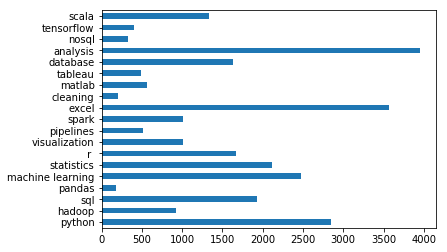

In [136]:
rows.sum().plot(kind='barh')

Now that the dummy variables have been created, the data itself is ready for machine learning, but the amount of data isn't ideal. There are too many positions with multiple potential titles.

### Creating a Dataframe for Machine Learning

The goal will be to remove all jobs with multiple potential titles as well as remove columns that don't aide in the machine learning process, and put together the two data sets rows and data.  

In [54]:
new_data=data.drop(['position', 'company', 'description' ,'city', 'state', 'hard skills'], axis=1)


In [56]:
rows.shape
        

(6953, 19)

In [86]:
new_data.shape

(6953, 1)

In [87]:
rows.index=new_data.index

In [88]:
ml_data=pd.concat([new_data, rows], axis=1)

In [89]:
ml_data.head()

,title,python,hadoop,sql,pandas,machine learning,statistics,r,visualization,pipelines,spark,excel,cleaning,matlab,tableau,database,analysis,nosql,tensorflow,scala
0,[scientist],0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,"[scientist, engineer]",0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1
2,[scientist],1,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0
3,"[analyst, scientist]",1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0
4,[engineer],0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [90]:
new=pd.DataFrame()
for i in ml_data.index:
    value=ml_data.loc[i, 'title']
    if len(value)==1:
        new=new.append(ml_data.loc[i, :])
new.head()

,r,analysis,cleaning,database,excel,hadoop,machine learning,matlab,nosql,pandas,pipelines,python,scala,spark,sql,statistics,tableau,tensorflow,title,visualization
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[scientist],0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,[scientist],1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[engineer],0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[analyst],0.0
10,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[analyst],0.0


In [77]:
new.shape

(2513, 20)

In [132]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neural_network import MLPClassifier

In [126]:

for i in new.index:
    value=new.loc[i, 'title']
    if 'analyst' in value:
        new.loc[i, 'int class']=1
    if 'engineer' in value:
        new.loc[i, 'int class']=2
    if 'scientist' in value:
        new.loc[i, 'int class']=3


In [118]:
all_X=new.drop(['title', 'int class'], axis=1)
all_Y=new['int class']

In [119]:
def select_features(df):
    RF=RandomForestClassifier(random_state=1, n_estimators=10)
     
    
    RFE=RFECV(RF, cv=10)
    RFE.fit(all_X, all_Y)
    
    best_columns=list(all_X.columns[RFE.support_])
        
    return best_columns

features=select_features(all_X)

In [120]:
features

[' r ',
 'analysis',
 'database',
 'excel',
 'machine learning',
 'python',
 'scala',
 'visualization']

In [129]:
def select_model(df, list_of_features):
    
    
    big_dict=[{"name": "KNeighborsClassifier",
              'estimator': KNeighborsClassifier(),
              'hyperparameters': {"n_neighbors":range(1,20,2),
                                 'weights':['distance','uniform'],
                                 'algorithm':['ball_tree', 'kd_tree', 'brute'],
                                 "p":[1,2]}},
             {"name": "LogisticRegression",
             'estimator': LogisticRegression(),
             'hyperparameters': {"solver": ["newton-cg", "lbfgs", "liblinear"]}},
             {'name':'RandomForestClassifier',
             'estimator': RandomForestClassifier(random_state=1),
             'hyperparameters': {'n_estimators': [4,6,9],
                                 'criterion':['entropy', 'gini'],
                                 'max_depth':[2,5,10],
                                 'max_features':['log2', 'sqrt'],
                                 'min_samples_leaf':[1,5,8],
                                 'min_samples_split':[2,3,5]
                                }}]
    
    
    list_of_dicts=[]
    
    for entry in big_dict:
        
        grid=GridSearchCV(entry['estimator'], entry['hyperparameters'], cv=10)
        grid.fit(all_X, all_Y)
        best_est=grid.best_estimator_
        best_score=grid.best_score_
        best_params=grid.best_params_
        small_dict={'Model':entry['name'],
                    'best estimator': best_est,
                    'best score': best_score,
                    'best parameters': best_params
        }
        list_of_dicts.append(small_dict)
        
    return list_of_dicts


output=select_model(all_X, features)

C:\Users\Stephen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stephen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stephen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stephen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stephen\Anaconda3\l

In [125]:
output

[{'Model': 'KNeighborsClassifier',
  'best estimator': KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=19, p=1,
             weights='uniform'),
  'best score': 0.7202546756864305,
  'best parameters': {'algorithm': 'brute',
   'n_neighbors': 19,
   'p': 1,
   'weights': 'uniform'}},
 {'Model': 'LogisticRegression',
  'best estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
            tol=0.0001, verbose=0, warm_start=False),
  'best score': 0.7055312375646637,
  'best parameters': {'solver': 'newton-cg'}},
 {'Model': 'RandomForestClassifier',
  'best estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
              max_depth=10, max_features='log2', max_leaf_nodes=None,
             

In [128]:
new['title'].value_counts(normalize=True)

[scientist]    0.678472
[engineer]     0.181854
[analyst]      0.139674
Name: title, dtype: float64

The highest score was .73, this is nothing to brag about and is only slightly better than putting scientist for every entry which would yield a score of .67. From this point, more features can be added or new models can be test. The first thing that will be handled. A multi layer neuronetwork will be tested to see if it is able to perform any better. 

In [133]:
def select_model(df, list_of_features):
    
    
    big_dict=[{"name": "KNeighborsClassifier",
              'estimator': KNeighborsClassifier(),
              'hyperparameters': {"n_neighbors":range(1,20,2),
                                 'weights':['distance','uniform'],
                                 'algorithm':['ball_tree', 'kd_tree', 'brute'],
                                 "p":[1,2]}},
             {"name": "LogisticRegression",
             'estimator': LogisticRegression(),
             'hyperparameters': {"solver": ["newton-cg", "lbfgs", "liblinear"]}},
             {'name':'RandomForestClassifier',
             'estimator': RandomForestClassifier(random_state=1),
             'hyperparameters': {'n_estimators': [4,6,9],
                                 'criterion':['entropy', 'gini'],
                                 'max_depth':[2,5,10],
                                 'max_features':['log2', 'sqrt'],
                                 'min_samples_leaf':[1,5,8],
                                 'min_samples_split':[2,3,5]
                                }},
             {"name": "MLPClassifier", 
             "estimator": MLPClassifier(),
             'hyperparameters': {"hidden_layer_sizes":[(100,), (1000,), (100, 100), (100, 100, 100)],
                                "solver" : ["lbfgs", "sgd", "adam"],
                                "learning_rate": ['constant', "invscaling", "adaptive"],
                                }}]
    
    list_of_dicts=[]
    
    for entry in big_dict:
        
        grid=GridSearchCV(entry['estimator'], entry['hyperparameters'], cv=10)
        grid.fit(all_X, all_Y)
        best_est=grid.best_estimator_
        best_score=grid.best_score_
        best_params=grid.best_params_
        small_dict={'Model':entry['name'],
                    'best estimator': best_est,
                    'best score': best_score,
                    'best parameters': best_params
        }
        list_of_dicts.append(small_dict)
        
    return list_of_dicts


output=select_model(all_X, features)

C:\Users\Stephen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stephen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stephen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stephen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stephen\Anaconda3\l

In [134]:
output


[{'Model': 'KNeighborsClassifier',
  'best estimator': KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=19, p=1,
             weights='uniform'),
  'best score': 0.7202546756864305,
  'best parameters': {'algorithm': 'brute',
   'n_neighbors': 19,
   'p': 1,
   'weights': 'uniform'}},
 {'Model': 'LogisticRegression',
  'best estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
            tol=0.0001, verbose=0, warm_start=False),
  'best score': 0.7055312375646637,
  'best parameters': {'solver': 'newton-cg'}},
 {'Model': 'RandomForestClassifier',
  'best estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
              max_depth=10, max_features='log2', max_leaf_nodes=None,
             

It looks like, despite the increase in processing power required by the MLP Classifier, there was no meaningful increase in accuracy. The next step would be to add more potential features, but it seems that this won't yield incredible results since the goal was to sort the job types given the hard skills. 

### Conclusion

Over the course of this project, the data has been cleaned, visualized and then procesesd for machine learning. The descriptions of the jobs provided the lists of hard skills that each position required. Analysis, Excell and Python being the top skills. During the machine learning steps in the process, multiple neural networks, random forest, k-neighbors and linear regressions were used. The highest performing model was the Random Forest. All of these machine learning models fell short of significance. Only being five percent better than saying all positions were data scientists rather than engineers or analysts. Final steps to wrap this up would be to continue to feature engineer and find new lines which seperate the positions. 